## Final Project

### Prepare Environment

Install libraries and load modules

In [ ]:
!pip install python-chess==1.2.0

     |████████████████████████████████| 140 kB 5.3 MB/s 
  Attempting uninstall: python-chess
    Found existing installation: python-chess 0.23.11
    Uninstalling python-chess-0.23.11:
      Successfully uninstalled python-chess-0.23.11


In [ ]:
# use ray which is 10x faster than the multiprocessing libary in python
!pip install -U ray

     |████████████████████████████████| 54.7 MB 38 kB/s 
     |████████████████████████████████| 118 kB 34.4 MB/s 


In [ ]:
!wget https://stockfishchess.org/files/stockfish_14.1_linux_x64.zip
!unzip -o stockfish_14.1_linux_x64.zip
!chmod +x stockfish_14.1_linux_x64/stockfish_14.1_linux_x64

--2021-11-18 22:27:08--  https://stockfishchess.org/files/stockfish_14.1_linux_x64.zip
Resolving stockfishchess.org (stockfishchess.org)... 104.25.158.9, 104.25.159.9, 172.67.80.249, ...
Connecting to stockfishchess.org (stockfishchess.org)|104.25.158.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28788691 (27M) [application/zip]
Saving to: ‘stockfish_14.1_linux_x64.zip’

stockfish_14.1_linu 100%[===================>]  27.45M   113MB/s    in 0.2s    

2021-11-18 22:27:09 (113 MB/s) - ‘stockfish_14.1_linux_x64.zip’ saved [28788691/28788691]

Archive:  stockfish_14.1_linux_x64.zip
  inflating: stockfish_14.1_linux_x64/AUTHORS  
  inflating: stockfish_14.1_linux_x64/Copying.txt  
  inflating: stockfish_14.1_linux_x64/info.txt  
  inflating: stockfish_14.1_linux_x64/stockfish_14.1_linux_x64  
   creating: stockfish_14.1_linux_x64/stockfish_14.1_src/
   creating: stockfish_14.1_linux_x64/stockfish_14.1_src/.github/
   creating: stockfish_14.1_linux_x64/stockfish

In [ ]:
import chess
import chess.pgn as pgn
import chess.engine

import psutil
import ray
from ray.util.multiprocessing import Pool

import numpy as np
import math
import random
from datetime import date
import time
from IPython.display import display
import pandas as pd

#import tensorflow as tf
from keras import optimizers
from keras import layers
from keras import models
from keras import backend

/usr/local/lib/python3.7/dist-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


In [ ]:
# increase limits for multiprocessing
import sys
sys.setrecursionlimit(10000)

if ray.is_initialized():
  ray.shutdown()
ray.init()
pool = Pool()

#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#print(tf.config.list_physical_devices('GPU'))

### Class: Node

The class node is used to build trees for use in a monte carlo tree search

In [ ]:
class node():
  def __init__(self):
    self.state = chess.Board()
    self.action = ''
    self.children = set()
    self.parent = None
    self.N = 0
    self.n = 0
    self.v = 0

choices = []

def reset_choices():
  global choices
  choices = []

### Class: ActionSpace

The ActionSpace class is used to interprete current state of a game

In [ ]:
class ActionSpace():
  def __init__(self, board):
    self.board = board

  def sample(self) -> str:
    """
    Returns a random legal move as a string in algebraic notation
    :return: move as a string
    """
    return random.choice(self.available_actions())

    def available_actions(self) -> list[str]:
      """
      Returns a list of legal moves as a list of strings where the moves
      are in algebraic notation
      :return: list of moves
      """
      legal_moves = list(self.board.legal_moves)
      legal_moves_str = [str(move) for move in legal_moves]
      return legal_moves_str

### Class: ChessEnv

Configures a chess environment for use in a game

In [ ]:
class ChessEnv():
  """
  Chess Environment. Player is always white. Opponent is black
  """

  def __init__(self, opponent):
    self.opponent = opponent
    self.board = chess.Board()
    self.game = chess.pgn.Game()
    self.game.headers['White'] = 'Player'
    if self.opponent != None:
      self.game.headers['Black'] = self.opponent.name
    self.game.headers['Date'] = str(date.today())
    self.node = self.game
    if self.opponent != None:
      self.action_space = ActionSpace(self.board)
    else:
      self.init_action_space()
      self.layer_board = np.zeros(shape=(8,8,8))
    self.init_layer_board()

  def init_action_space(self):
    """
    Initialize the actions space
    """
    self.action_space = np.zeros(shape=(64,64))
  
  def init_layer_board(self):
    """
    Initialize the numerical representation of the envrionment
    """
    mapper = {'p': 0, 'r': 1, 'n': 2, 'b': 3, 'q': 4, 'k': 5, 'P': 0, 'R': 1, 'N': 2, 'B': 3, 'Q': 4, 'K': 5}
    self.layer_board = np.zeros(shape=(8,8,8))
    for i in range(64):
      row = i // 8
      col = i % 8
      piece = self.board.piece_at(i)
      if piece == None:
        continue
      elif piece.symbol().isupper():
        sign = 1
      else:
        sign = -1
      layer = mapper[piece.symbol()]
      self.layer_board[layer, row, col] = sign
    if self.board.turn:
      self.layer_board[6, :, :] = 1 / self.board.fullmove_number
    if self.board.can_claim_draw():
      self.layer_board[7, :, :] = 1

  def _observation(self) -> str:
    """
    Returns the state of the game in Forsyth-Edwards Notation (FEN)
    :return: observation
    """
    return self.board.fen()

  def _is_done(self) -> bool:
    """
    :return: Return True if the game is over, else False
    """
    return self.board.is_game_over()

  def _reward(self) -> int:
    """
    Returns a reward from white's perspective
    Game not over = 0
    Win = +1
    Loss = -1
    Draw = 0
    :return: reward
    """
    if not self._is_done():
      reward = 0
    else:
      result = self.board.result()
      if result == '1-0':
        reward = 1
      elif result == '0-1':
        reward = -1
      elif result == '1/2-1/2':
        reward = 0
      else:
        raise Exception('Unknown end game state')
    return reward

  def reset(self) -> str:
    """
    Resets the game and returns an observation
    :return: observaction
    """
    self.board = chess.Board()
    self.game = chess.pgn.Game()
    self.game.headers['White'] = 'Player'
    if self.opponent != None:
      self.game.headers['Black'] = self.opponent.name
      self.init_action_space()
    self.game.headers['Date'] = str(date.today())
    self.node = self.game
    self.init_layer_board()
    return self._observation

  def render_image(self, **kwargs):
    return chess.svg.board(self.board, **kwargs)

  def render_txt(self):
    print('\n')
    print(self.board)
    print('\n')

  def render_image_jupyter(self):
    display(self.board)

  def step(self, action: str):
    """
    :param action: action in san
    """
    self.board.push_san(action)

  def step_numerical(self, action):
    """
    Run a step
    Args:
      action: tuple of 2 integers
        Move from, Move to
    Returns:
      episode end: Boolean
        Whether the episode has ended
      reward: int
        Difference in material value after the move
    """
    piece_balance_before = self.get_material_value()
    self.board.push(action)
    self.init_layer_board()
    piece_balance_after = self.get_material_value()
    if self.board.result() == '*':
      opponent_move = self.get_random_action()
      self.board.push(opponent_move)
      self.init_layer_board()
      capture_reward = piece_balance_after - piece_balance_before
      if self.board.result() == '*':
        reward = 0 + capture_reward
        episode_end = False
      else:
        reward = 0 + capture_reward
        episode_end = True
    else:
      capture_reward = piece_balance_after - piece_balance_before
      reward = 0 + capture_reward
      episode_end = True
    if self.board.is_game_over():
      reward = 0
      episode_end = True
    return episode_end, reward

  def get_random_action(self):
    """
    Sample a random action
    Returns: move
      A legal chess move
    """
    legal_moves = [x for x in self.board.generate_legal_moves()]
    legal_moves = np.random.choice(legal_moves)
    return legal_moves

  def get_material_value(self):
    """
    Sums up the material balance using Reinfield values
    Returns: The material balance on the board
    """
    pawns = 1 * np.sum(self.layer_board[0, :, :])
    rooks = 5 * np.sum(self.layer_board[1, :, :])
    minor = 3 * np.sum(self.layer_board[2:4, :, :])
    queen = 9 * np.sum(self.layer_board[4, :, :])
    return pawns + rooks + minor + queen

  def project_legal_moves(self):
    """
    Create a mask of legal actions
    Returns: np.ndarray with shape (64, 64)
    """
    self.action_space = np.zeros(shape=(64, 64))
    moves = [[x.from_square, x.to_square] for x in self.board.generate_legal_moves()]
    for move in moves:
      self.action_space[move[0], move[1]] = 1
    return self.action_space

### Class: MCTSAgent()

Create an agent that uses monte carlo tree search to determine a move

In [ ]:
class MCTSAgent():
  def __init__(self, name: str, is_white: bool, multithreading=True):
    self.name = name
    self.is_white = is_white
    self.multithreading = multithreading
    print('Created Agent ''{}'' as {}; multithreading: {}'.\
          format(name, 'White' if is_white else 'Black', multithreading))

  def expand(self, current_node):
    """
    Expanding is used to increase the options further in the game by expanding
    the selected node and creating many children nodes
    :param current_node: node to expand, is_white: white or black player
    :return: the current node with the expanded children
    """
    if len(current_node.children) == 0:
      return current_node
    expanded_child = self.mcts_identify_best_ucb(current_node, self.is_white, True)
    return self.expand(expanded_child)

  def rollout(self, current_node):
    """
    Run a simulated rollout from M until a terminal state is found. The terminal state 
    contains a result (value) that will be returned to upwards in the is 
    backpropagation phase
    params: current_node: node to simulate
    return: the terminal state
    """
    if current_node.state.is_game_over():
      board = current_node.state
      if board.result() == '1-0':
        return 1, current_node
      elif board.result() == '0-1':
        return -1, current_node
      else:
        return 0.5, current_node
    
    all_moves = [current_node.state.san(i) for i in list(current_node.state.legal_moves)]

    for move in all_moves:
      tmp_state = chess.Board(current_node.state.fen())
      tmp_state.push_san(move)
      child = node()
      child.state = tmp_state
      child.parent = current_node
      current_node.children.add(child)
    
    random_state = random.choice(list(current_node.children))

    return self.rollout(random_state)

  def rollback(self, current_node, reward):
    """
    After the simulation phase, a result is returned. All nodes from M up to R 
    will be updated by adding the result to their value and increase the count of visits at each node
    params: current_node: the node with all children, reward: the reward to roll backpropagate
    returns: current_node with updated rewards
    """
    current_node.n += 1
    current_node.v += reward
    while(current_node.parent != None):
      current_node.N += 1
      current_node = current_node.parent
    return current_node

  def mcts_parallel_operation(self, item):
    """
    Performs a multiprocess exeuction to obtain the upper control bound of a given node
    params: i: process, child: node, idx: object reference id for node
    returns: tupple of idx, child, ucb
    """
    # Calculate the upper confidence bounds (UCB)
    child = item[0]
    idx = item[1]
    ucb = child.v + 2 * (math.sqrt(math.log(child.N + math.e + (10**-6)) / (child.n + (10**-10))))
    result = (idx, ucb)
    return result

  def mcts_identify_best_ucb(self, current_node, is_white, flip = False):
    """
    Determines the upper confidence bounds of each child in a given node
    params: current_node: the node, is_white: white or black player
    returns: sel_child: the child with the best upper confidence bounds
    """
    # create children to calculate UCB
    ref_child = {}
    pool_members = []
    idx = 0

    # build pool members to parallelize
    for child in current_node.children:
      ref_child[idx] = child
      pool_members.append((child, idx))
      idx+=1

    if self.multithreading:
      # run parallel collection of UCB across al node children
      global pool
      mcts_list = pool.map(self.mcts_parallel_operation, pool_members, chunksize=1000000)
    else:
      mcts_list = map(self.mcts_parallel_operation, pool_members)
    mcts_list = list(mcts_list)

    if flip:
      _param = 0 if is_white else 1
    else:
      _param = is_white

    if _param:
      max_idx = np.argmax(np.array(mcts_list)[:,1])
      max_idx = np.array(mcts_list)[max_idx,0]
      sel_child = ref_child[max_idx]
    else:
      min_idx = np.argmin(np.array(mcts_list)[:,1])
      min_idx = np.array(mcts_list)[min_idx,0]
      sel_child = ref_child[min_idx]

    mcts_list.clear()
    return sel_child

  # Monte Carlo Tree Search
  def observe(self, current_node, is_over=False, iterations=10):
    """
    Performs a monte carlo tree search on a given node
    params: the node to perform a MCTS
    returns: selected_move: the best move
    """
    if is_over:
      return -1
    root = node()
    root.state = current_node
    current_node = root

    all_moves = [current_node.state.san(i) for i in list(current_node.state.legal_moves)]
    map_state_move = dict()

    for move in all_moves:
      tmp_state = chess.Board(current_node.state.fen())
      tmp_state.push_san(move)
      child = node()
      child.state = tmp_state
      child.parent = current_node
      current_node.children.add(child)
      map_state_move[child] = move

    while(iterations > 0):
      sel_child = self.mcts_identify_best_ucb(current_node, self.is_white)
      ex_child = self.expand(sel_child)
      reward, state = self.rollout(ex_child)
      current_node = self.rollback(state, reward)

      iterations -= 1

    selected_move = ''
    sel_child = self.mcts_identify_best_ucb(current_node, self.is_white)
    selected_move = map_state_move[sel_child]
    
    return selected_move

### Class: StockfishAgent()

Create an agent that uses the stockfish engine

In [ ]:
class StockfishAgent():
  def __init__(self, name: str, is_white: bool, skill_lvl = 1):
    self.name = name
    self.is_white = is_white
    self.engine = chess.engine.SimpleEngine.popen_uci('stockfish_14.1_linux_x64/stockfish_14.1_linux_x64')
    # set skill level
    self.engine.configure({"Skill Level": skill_lvl})

    print('Created Agent ''{}'' as {}; Using Stockfish engine lvl: {}'.\
          format(name, 'White' if is_white else 'Black', skill_lvl))
    
  def observe(self, state):
    board = state
    result = self.engine.play(board, chess.engine.Limit(time=0.1))
    selected_move = str(result.move)
    return selected_move

###Class: ActorCritic()

Create an agent that uses actor critic methods that is guided by the functions
- actor - a policy function that picks what moves to play
- criric - tracks whether the agent is ahead or behind in the game

In [ ]:
#from tensorflow.keras import optimizers
#from tensorflow.keras import layers
#from tensorflow.keras import models
#from tensorflow.keras import backend

In [ ]:
class ActorCriticAgent():
  def __init__(self, gamma=0.5, network='cnn', lr=0.1, verbose=0):
    """
    Agent that plays the white pieces using the actor critic learning method
    Args:
      gamma: float
        Temporal discount factor
      network: str
        'linear' or 'conv'
      lr: float
        Learning reate, default is 0.01
      verbose: int
        The level of verbosity used in the model
    """
    self.gamma = gamma
    self.lr = lr
    self.verbose = verbose
    
    self.weight_memory = []
    self.long_term_mean = []
    if network == 'cnn':
      self.model = self.build_network_cnn()
    elif network == 'cnn_pg':
      self.model = self.built_network_cnn_policy_gradients()
    else:
      Exception('Error: Incorrect network defined when setting up Agent')

  def build_network_cnn(self):
    """
    Initializes a convolutional neural network (CNN)
    """
    #optimizer = optimizers.SGD(learning_rate=self.lr, momentum=0.0, decay=0.0, nesterov=False)
    optimizer = optimizers.gradient_descent_v2.SGD(learning_rate=self.lr, momentum=0.0, decay=0.0, nesterov=False)
    input_layer = layers.Input(shape=(8, 8, 8), name='board_layer')
    inter_layer_1 = layers.Conv2D(filters=1, kernel_size=(1,1), data_format='channels_first')(input_layer)
    inter_layer_2 = layers.Conv2D(filters=1, kernel_size=(1,1), data_format='channels_first')(input_layer)
    flatten_1 = layers.Reshape(target_shape=(1, 64))(inter_layer_1)
    flatten_2 = layers.Reshape(target_shape=(1, 64))(inter_layer_2)
    output_dot_layer = layers.Dot(axes=1)([flatten_1, flatten_2])
    output_layer = layers.Reshape(target_shape=(4096,))(output_dot_layer)
    model = models.Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model
  
  def built_network_cnn_policy_gradients(self):
    """
    Convolutional neural network (CNN) for policy gradients
    """
    #optimizer = optimizers.SGD(learning_rate=self.lr, momentum=0.0, decay=0.0, nesterov=False)
    optimizer = optimizers.gradient_descent_v2.SGD(learning_rate=self.lr, momentum=0.0, decay=0.0, nesterov=False)
    input_layer = layers.Input(shape=(8, 8, 8), name='board_layer')
    rewards = layers.Input(shape=(1,), name='Rewards')
    legal_moves = layers.Input(shape=(4096,), name='legal_move_mast')
    inter_layer_1 = layers.Conv2D(filters=1, kernel_size=(1,1), data_format='channels_first')(input_layer)
    inter_layer_2 = layers.Conv2D(filters=1, kernel_size=(1,1), data_format='channels_first')(input_layer)
    flatten_1 = layers.Reshape(target_shape=(1, 64))(inter_layer_1)
    flatten_2 = layers.Reshape(target_shape=(1, 64))(inter_layer_2)
    output_dot_layer = layers.Dot(axes=1)([flatten_1, flatten_2])
    output_layer = layers.Reshape(target_shape=(4096,))(output_dot_layer)
    softmax_layer = layers.Activation('softmax')(output_layer)
    legal_softmax_layer = layers.Multiply()([legal_moves, softmax_layer]) # select legal moves
    model = models.Model(inputs=[input_layer, rewards, legal_moves], outputs=[legal_softmax_layer])
    model.compile(optimizer=optimizer, loss=self.policy_gradient_loss(rewards))
    return model
  
  def policy_gradient_loss(self, Returns):
    def modified_crossentropy(action, action_probs):
      cost = backend.categorical_crossentropy(action, action_probs, from_logits=False, axis=1) * Returns
      return backend.mean(cost)
    return modified_crossentropy
  
  def update_model(self):
    """
    Updates to model for use with bootstrapping
    """
    #optimizer = optimizers.SGD(learning_rate=self.lr, momentum=0.0, decay=0.0, nesterov=False)
    optimizer = optimizers.gradient_descent_v2.SGD(learning_rate=self.lr, momentum=0.0, decay=0.0, nesterov=False)
    self.updated_model = models.clone_model(self.model)
    self.updated_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    self.updated_model.set_weights(self.model.get_weights())

  def network_update(self, minibatch):
    """
    Updates the Q-network using samples from the minibatch
    Args:
      minibatch: list
        The minibatch contains the states, moves, rewards and new states
    Returns:
      td_errors: np.array
        array of temporal difference errors
    """

    # Prepare separate lists
    states, moves, rewards, new_states = [], [], [], []
    td_errors = []
    episode_ends = []
    for sample in minibatch:
      states.append(sample[0])
      moves.append(sample[1])
      rewards.append(sample[2])
      new_states.append(sample[3])

      # Episode end detection
      if np.array_equal(sample[3], sample[3] * 0):
        episode_ends.append(0)
      else:
        episode_ends.append(1)
    
    # The Q target
    q_target = np.array(rewards) + np.array(episode_ends) * self.gamma * np.max(self.updated_model.predict(np.stack(new_states, axis=0)), axis=1)
    
    # The Q value for remaining actions
    q_state = self.model.predict(np.stack(states, axis=0)) # batch x 64 x 64

    # Combine the Q target with the other Q values
    q_state = np.reshape(q_state, (len(minibatch), 64, 64))
    for idx, move in enumerate(moves):
      td_errors.append(q_state[idx, move[0], move[1]] - q_target[idx])
      q_state[idx, move[0], move[1]] = q_target[idx]
    q_state = np.reshape(q_state, (len(minibatch), 4096))

    # Perform a step of minibatch Gradient Descent
    self.model.fit(x=np.stack(states, axis=0), y=q_state, epochs=1, verbose=0)

    return td_errors

  def get_action_values(self, state):
    """
    Get action values of a state
    Args:
      state: np.ndarray with shape (8,8,8)
        layer_board representation
    Returns:
      action avalues
    """
    return self.updated_model.predict(state) + np.random.randn() * 1e-9

  def policy_gradient_update(self, states, actions, rewards, action_spaces):
    """
    Update parameters with Monte Carlo Policy Gradient algorithm
    Args:
      states: (list of tuples) state sequence in episode
      actions: action sequence in episode
      rewards: rewards sequence in episode
    """
    n_steps = len(states)
    Returns = []
    targets = np.zeros((n_steps, 64, 64))
    for t in range(n_steps):
      action = actions[t]
      targets[t, action[0], action[1]] = 1
      R = rewards[t, action[0] * 64 + action[1]]
      Returns.append(R)
    
    train_returns = np.stack(Returns, axis=0) #np.stack(Returns, axis=0)
    targets = targets.reshape((n_steps, 4096))
    self.weight_memory.append(self.model.get_weights())
    #self.model.fit(x=[np.stack(states, axis=0), train_returns, np.concatenate(action_spaces, axis=0)], y=[np.stack(targets, axis=0)], verbose=self.verbose)
    #self.model.fit(x=[tf.stack(states, axis=0), train_returns, np.concatenate(action_spaces, axis=0)], 
    #               y=[tf.stack(targets, axis=0)], verbose=self.verbose)
    
  def save_model(self, name):
    self.model.save_weights(name)
  
  def load_model(self, name):
    self.model.load_weights(name)

In [ ]:
class ActorCritic():
  def __init__(self, actor, critic, env):
    """
    Actor Critic object to learn chess
    Args:
      actor: policy gradient agent
      critic: Q-learning agent
      env: the chess environment
      memsize: maximum amount of games to retain in-memory
    """
    self.actor = actor
    self.critic = critic
    self.env = env
    self.reward_trace = []
    self.action_value_memory = []
    self.memory = []
    self.sampling_probs = []

  def learn(self, iters=100, c=10):
    """
    Runs the Q learning algorithm. The final iteration will play greedy
    Args:
      iters: int
        amount of games to train
      c: int
        update the network every c games
    Returns: pgn (str)
      pgn string describing the final game
    """
    for i in range(iters):
      if i % c == 0:
        self.critic.update_model()
      self.env.reset()
      end_state = self.play_game(i)

    _pgn = pgn.Game.from_board(self.env.board)
    reward_smooth = pd.DataFrame(self.reward_trace)
    reward_smooth.rolling(window=10, min_periods=0).mean().plot()

    return _pgn
  
  def play_game(self, i, greedy=False, maxiter=25):
    """
    Play a game of chess
    Args:
      i: int
        game count, determines the epsilon (exploration rate)
      greedy: boolean
        if greedy, no exploration is done
      maxiter: int
        maximum amount of steps per game
    """
    episode_end = False
    turn_count = 0

    # play game
    state = self.env.layer_board
    start = time.time()
    while not episode_end:
      state = self.env.layer_board
      action_space = self.env.project_legal_moves() # determine which moves are legal
      action_probs = self.actor.model.predict([np.expand_dims(state, axis=0), np.zeros((1,1)), action_space.reshape(1, 4096)])
      self.action_value_memory.append(action_probs)
      action_probs = action_probs / action_probs.sum()
      move = np.random.choice(range(4096), p=np.squeeze(action_probs))
      move_from = move // 64
      move_to = move % 64
      moves = [x for x in self.env.board.generate_legal_moves() if \
               x.from_square == move_from and x.to_square == move_to]
      assert len(moves) > 0 # should not be possible
      if len(moves) > 1:
        move = np.random.choice(moves) # If there are multiple max-moves, pick a random one
      elif len(moves) == 1:
        move = moves[0]

      episode_end, reward = self.env.step_numerical(move)
      new_state = self.env.layer_board
      turn_count += 1
      if turn_count > maxiter:
        episode_end = True
        reward = 0
      if episode_end:
        new_state = new_state * 0
      
      self.memory.append([state, (move_from, move_to), reward, new_state, action_space.reshape(1,4096)])
      self.sampling_probs.append(1)
      self.reward_trace.append(reward)
    
    self.update_actor_critic(turn_count)

    # report results and return
    reward = self.env._reward()
    if reward == 1:
      result = '(White) - Won the Game'
    elif reward == -1:
      result = '(Black) - Won the Game'
    else:
      result = 'Game was a Draw'
    end = time.time()
    duration = end - start
    print('Finished Game: {}, Duration: {}, Result: {}'.format(i+1, duration, result))

    return self.env.board

  def sample_memory(self, turn_count):
    """
    Obtains a sample from memory for experience replay
    Args:
      turn_count: int
        limits the size of the minibatch
    Returns: tuple
        a mini-batch of experiences
        indices of chosen experiences
    """
    minibatch = []
    memory = self.memory[:-turn_count]
    probs = self.sampling_probs[:-turn_count]
    sample_probs = [probs[n] / np.sum(probs) for n in range(len(probs))]
    indices = np.random.choice(range(len(memory)), min(1028, len(memory)), replace=False, p=sample_probs)
    for i in indices:
      minibatch.append(memory[i])
    return minibatch, indices

  def update_actor_critic(self, turn_count):
    """
    Updates the actor critic
    """
    if turn_count < len(self.memory):
      # get a sample
      minibatch, indices = self.sample_memory(turn_count)

      # update critic and find td errors for prioritized experience replay
      td_errors = self.critic.network_update(minibatch)

      # Get a Q value from the critic
      states = [x[0] for x in minibatch]
      actions = [x[1] for x in minibatch]
      Q_est = self.critic.get_action_values(np.stack(states, axis=0))
      action_spaces = [x[4] for x in minibatch]

      self.actor.policy_gradient_update(states, actions, Q_est, action_spaces) # true

      # Update sampling probs
      for n, i in enumerate(indices):
        self.sampling_probs[i] = np.abs(td_errors[n])

## next when i get back

**Train Actor Critic Agent**

In [ ]:
# initialize board
board = ChessEnv(opponent=None)

# create critic
critic = ActorCriticAgent(network='cnn', lr=0.1)
critic.update_model()
# create actor
actor = ActorCriticAgent(network='cnn_pg', lr=0.3)

# learn
run_learning = ActorCritic(actor=actor, critic=critic, env=board)
_pgn = run_learning.learn(iters=1000)



Finished Game: 1, Duration: 1.8753292560577393, Result: Game was a Draw
Finished Game: 2, Duration: 2.7089829444885254, Result: Game was a Draw
Finished Game: 3, Duration: 2.0150907039642334, Result: Game was a Draw
Finished Game: 4, Duration: 2.0608747005462646, Result: Game was a Draw
Finished Game: 5, Duration: 2.469783306121826, Result: Game was a Draw
Finished Game: 6, Duration: 2.1436710357666016, Result: Game was a Draw
Finished Game: 7, Duration: 1.8553986549377441, Result: (Black) - Won the Game
Finished Game: 8, Duration: 2.210645914077759, Result: Game was a Draw
Finished Game: 9, Duration: 2.1152987480163574, Result: Game was a Draw
Finished Game: 10, Duration: 2.268937587738037, Result: Game was a Draw
Finished Game: 11, Duration: 2.655080556869507, Result: Game was a Draw
Finished Game: 12, Duration: 2.290318012237549, Result: Game was a Draw
Finished Game: 13, Duration: 2.2912819385528564, Result: Game was a Draw
Finished Game: 14, Duration: 2.3362808227539062, Result: G

### Test Agents

In [ ]:
def play_game(player, opponent):
  # Create environment
  env = ChessEnv(opponent=opponent)

  # Play Game
  ## Starts with player
  is_white = 1
  total_game_time = 0

  while not env._is_done():
    # set up base variables
    #root = node()
    #root.state = env.board
    state = env.board
    action = None
    current_player = player if is_white else env.opponent

    # observe action to take
    start = time.time()
    if is_white:
      action = player.observe(state)
    else:
      action = env.opponent.observe(state)
    end = time.time()
    duration = end - start
    total_game_time += duration
    # perform action
    env.step(action)
    print('{} Moved: {}, time taken to move: {:.2f}s'.format(current_player.name, action, duration))
    

    if not is_white:
      env.render_image_jupyter()
    is_white ^= 1

  return env, total_game_time

Created Agent Player as White; multithreading: False
============================== Starting Episode: 1 ==============================
Created Agent Stockfish Agent as Black; Using Stockfish engine
Player Moved: a3, time taken to move: 24.70s
Stockfish Agent Moved: d7d5, time taken to move: 0.11s


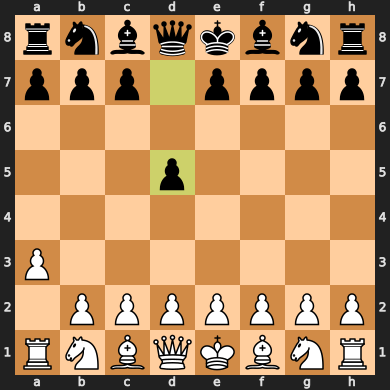

Player Moved: Nc3, time taken to move: 24.18s
Stockfish Agent Moved: d5d4, time taken to move: 0.10s


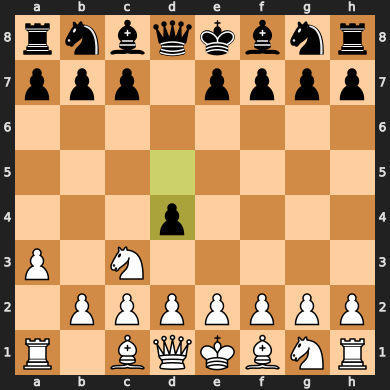

Player Moved: Nh3, time taken to move: 26.21s
Stockfish Agent Moved: d4c3, time taken to move: 0.10s


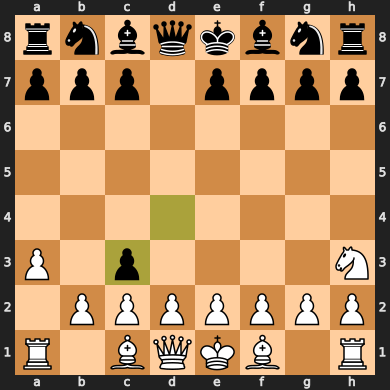

Player Moved: d3, time taken to move: 21.82s
Stockfish Agent Moved: c8h3, time taken to move: 0.10s


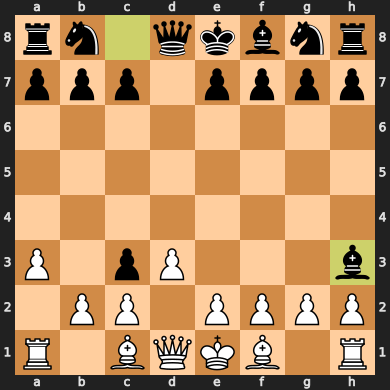

Player Moved: Qd2, time taken to move: 24.28s
Stockfish Agent Moved: c3d2, time taken to move: 0.10s


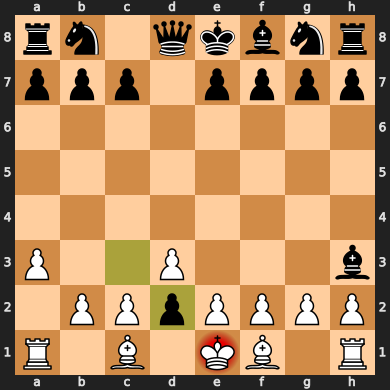

Player Moved: Bxd2, time taken to move: 21.85s
Stockfish Agent Moved: h3g4, time taken to move: 0.10s


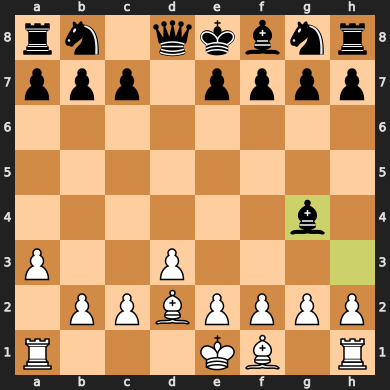

Player Moved: Ba5, time taken to move: 23.74s
Stockfish Agent Moved: b8c6, time taken to move: 0.10s


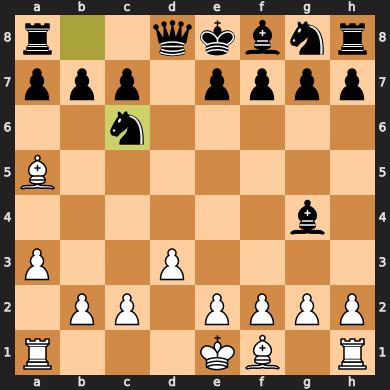

Player Moved: Ra2, time taken to move: 18.21s
Stockfish Agent Moved: c6a5, time taken to move: 0.10s


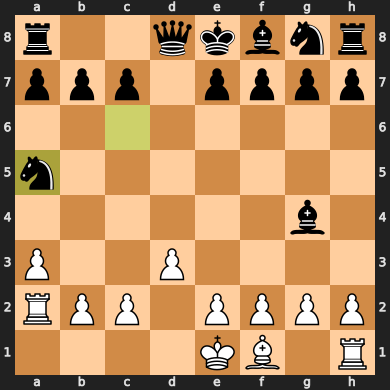

Player Moved: Kd1, time taken to move: 21.80s
Stockfish Agent Moved: g4e6, time taken to move: 0.10s


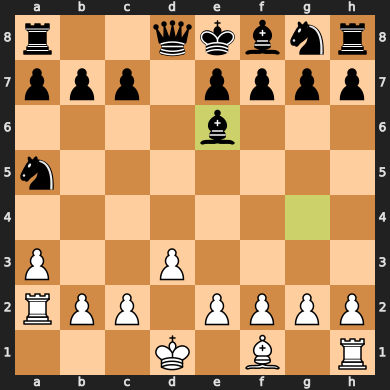

Player Moved: c3, time taken to move: 16.41s
Stockfish Agent Moved: e6a2, time taken to move: 0.11s


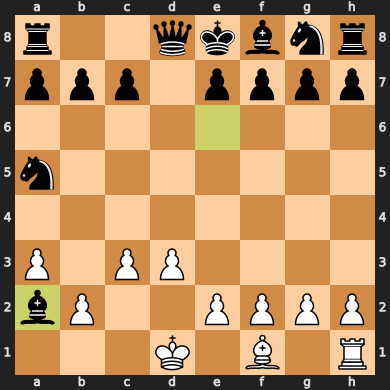

Player Moved: Kc1, time taken to move: 18.60s
Stockfish Agent Moved: g8f6, time taken to move: 0.10s


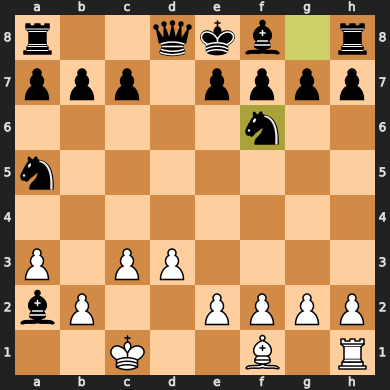

Player Moved: d4, time taken to move: 20.23s
Stockfish Agent Moved: f6g4, time taken to move: 0.10s


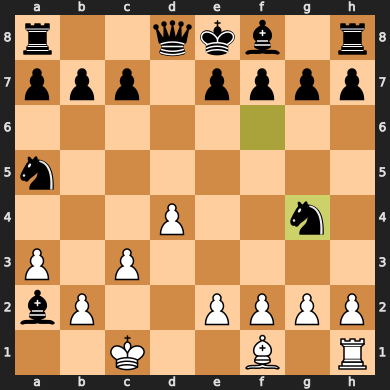

Player Moved: a4, time taken to move: 16.03s
Stockfish Agent Moved: a5b3, time taken to move: 0.10s


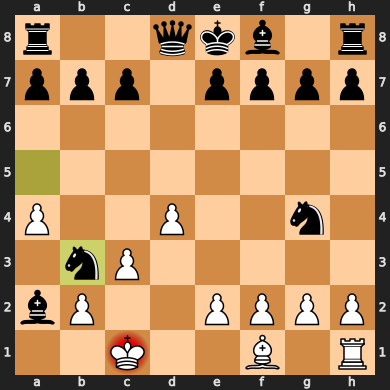

Player Moved: Kd1, time taken to move: 17.69s
Stockfish Agent Moved: g4f2, time taken to move: 0.10s


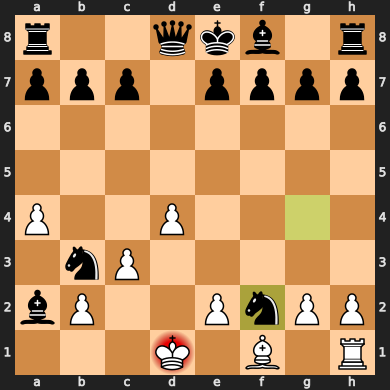

Player Moved: Ke1, time taken to move: 19.44s
Stockfish Agent Moved: f2h1, time taken to move: 0.10s


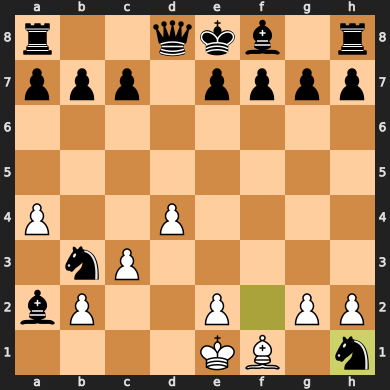

Player Moved: d5, time taken to move: 11.14s
Stockfish Agent Moved: d8d5, time taken to move: 0.10s


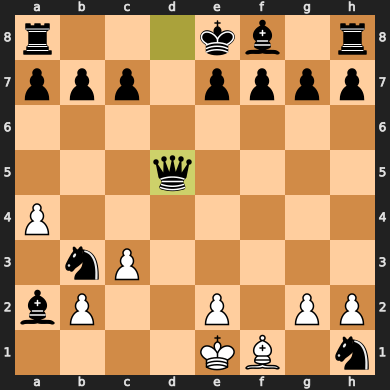

Player Moved: a5, time taken to move: 15.18s
Stockfish Agent Moved: d5d2, time taken to move: 0.04s


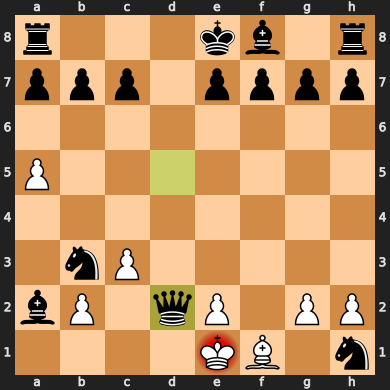

Total Game Time: 343.19735765457153s

Final Board:


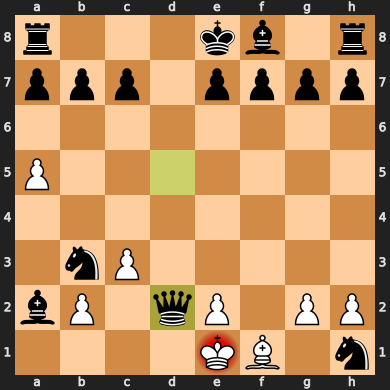


(Black) Stockfish Agent - Won the Game


In [ ]:
# Create opponent
#opponent = MCTSAgent(name='MCTS Based Agent', is_white=False, multithreading=False)
player = MCTSAgent(name='Player', is_white=True, multithreading=False)

games = 1
episode = 0

while episode < games:
  print('='*30 + ' Starting Episode: {} '.format(episode+1) + '='*30)
  opponent = StockfishAgent(name='Stockfish Agent', is_white=False)
  env, total_game_time = play_game(player, opponent)

  print('Total Game Time: {}s'.format(total_game_time))
  print('')
  print('Final Board:')
  env.render_image_jupyter()
  print('')

  reward = env._reward()

  if reward == 1:
    print('(White) {} - Won the Game'.format(player.name))
  elif reward == -1:
    print('(Black) {} - Won the Game'.format(env.opponent.name))
  else:
    print('Game was a Draw between {} vs. {}'.format(player.name, env.opponent.name))

  episode += 1